In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_columns', 500)

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from  datetime import timedelta
import sys

sys.path.append("/Users/clemens/Documents/courses/DS-Lab/Baselines/")
from choetkiertikul_helpers import *
from data_utils import make_datetime, shuffle_columns_within_group
import utils

In [2]:
pair_file_standard = "../Cache/backup/final_candidates_pairs.pickle"
pair_file_elvis = "../Cache/ttm_elvis_final_candidates_pairs_statSim.pickle"
pair_file_elvis_jannson = "../Cache/ttm_elvis_final_candidates_pairs_janson.pickle"

to_use = pair_file_standard
raw_pairs = pd.read_pickle(to_use).reset_index()

In [3]:
raw_pairs.head()

,index,answerer_id,type_of_answerer,label,question_id,question_tags,creationdate_question,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,prevalent_topic,titleLength,questionLength,nCodeBlocks,nEquationBlocks,nExternalLinks,nTags,readability,user_features_age,user_id,creationdate_user,_reputation_global,plattformage,numberquestions,numberanswers,numberacceptedanswers,user_tags,upvotes,downvotes,reputation
0,0,5764.0,incorrect_pick,False,130867,<machine-learning><inference><terminology>,2015-01-01 08:12:07.280,0.283907,0.095939,0.006466,0.028632,0.011374,0.004282,0.228753,0.340049,0.000584,0.000014,7.0,25.0,336.0,0.0,0.0,0.0,3.0,29.272727,08:12:07.280000,5764.0,2011-08-10 12:59:37.990,1166.0,1239 days 11:00:22.010000,1.0,8.0,3.0,<r><time-series><r><data-visualization><barplo...,33.0,1.0,105.0
1,1,5.0,incorrect_pick,False,130867,<machine-learning><inference><terminology>,2015-01-01 08:12:07.280,0.283907,0.095939,0.006466,0.028632,0.011374,0.004282,0.228753,0.340049,0.000584,0.000014,7.0,25.0,336.0,0.0,0.0,0.0,3.0,29.272727,08:12:07.280000,5.0,2010-07-19 19:03:57.227,9603.0,1626 days 04:56:02.773000,17.0,100.0,33.0,<machine-learning><pac-learning><data-visualiz...,1536.0,21.0,800.0
2,2,36041.0,incorrect_pick,False,130867,<machine-learning><inference><terminology>,2015-01-01 08:12:07.280,0.283907,0.095939,0.006466,0.028632,0.011374,0.004282,0.228753,0.340049,0.000584,0.000014,7.0,25.0,336.0,0.0,0.0,0.0,3.0,29.272727,08:12:07.280000,36041.0,2013-12-11 15:34:17.843,41660.0,385 days 08:25:42.157000,2.0,289.0,49.0,<time-series><conditional-expectation><disaggr...,370.0,30.0,9685.0
3,3,9866.0,incorrect_pick,False,130867,<machine-learning><inference><terminology>,2015-01-01 08:12:07.280,0.283907,0.095939,0.006466,0.028632,0.011374,0.004282,0.228753,0.340049,0.000584,0.000014,7.0,25.0,336.0,0.0,0.0,0.0,3.0,29.272727,08:12:07.280000,9866.0,2012-03-15 09:34:49.133,1420.0,1021 days 14:25:10.867000,NaN,10.0,3.0,<r><probability><econometrics><panel-data><val...,23.0,0.0,390.0
4,4,29068.0,incorrect_pick,False,130867,<machine-learning><inference><terminology>,2015-01-01 08:12:07.280,0.283907,0.095939,0.006466,0.028632,0.011374,0.004282,0.228753,0.340049,0.000584,0.000014,7.0,25.0,336.0,0.0,0.0,0.0,3.0,29.272727,08:12:07.280000,29068.0,2013-08-12 17:16:09.660,1617.0,506 days 06:43:50.340000,14.0,31.0,11.0,<regression><logistic><modeling><sas><missing-...,77.0,1.0,355.0


In [4]:
only_use_known_users = False

if only_use_known_users:
    pairs_known_users = raw_pairs[raw_pairs.numberanswers >= 1] 
    all_pairs =  utils.retain_only_questions_with_at_least_one_answer(pairs_known_users)
    #all_pairs = pairs_known_users
else:
    all_pairs= raw_pairs

label    1.0
dtype: float64


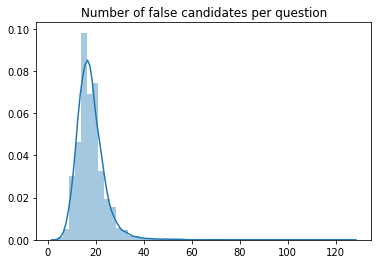

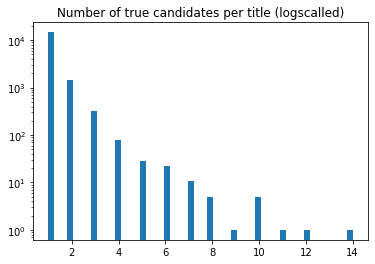

In [5]:
# candidates per question, false candidates
wrong_candidates = all_pairs[all_pairs.label == False].question_id.value_counts().values
wrong_candidates

true_candidates = all_pairs.groupby('question_id').agg({'label':'sum'})
print(true_candidates.min())
sb.distplot(wrong_candidates)
plt.title("Number of false candidates per question")
plt.figure()
_ = plt.hist(true_candidates.label.values, bins=50)
plt.title("Number of true candidates per title (logscalled)")
plt.yscale('log')

14.1% of true answer candidates selected


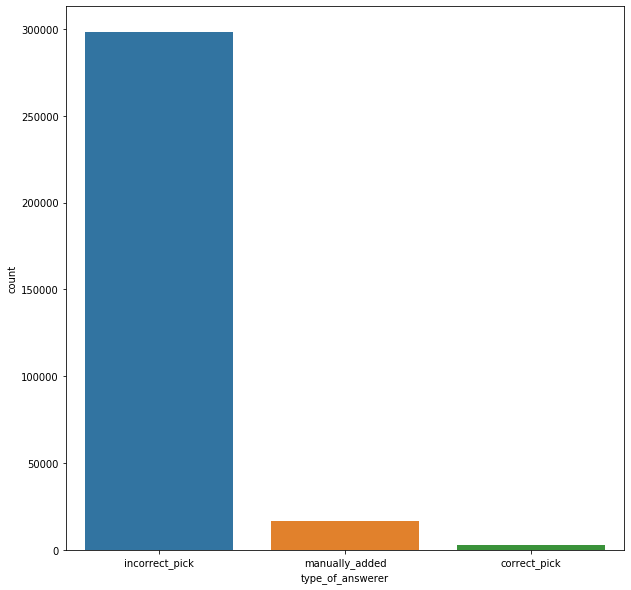

In [6]:
plt.figure(figsize=(10,10))
sb.countplot(all_pairs.type_of_answerer)

fraction_correctly_found = np.count_nonzero(all_pairs.type_of_answerer == "correct_pick") / np.count_nonzero(all_pairs.type_of_answerer != "incorrect_pick")
print("{:.1f}% of true answer candidates selected".format(fraction_correctly_found*100))

# only users with at least one answer 17%
# all users 14.1%
# TTM only users iwth at least one: 11%

In [7]:
np.mean(1/np.arange(1, 101))
#all_pairs.question_tags.str.len().min()

0.05187377517639621

In [9]:
training_questions_start_time = make_datetime("01.01.2015 00:00")
training_questions_end_time = make_datetime("01.06.2016 00:01")
testing_questions_start_time = make_datetime("01.06.2016 00:02")
testing_questions_end_time = make_datetime("31.12.2016 23:59")

feature_cols_for_training = ['titleLength', 'questionLength', 'nCodeBlocks', 'nEquationBlocks', 'nExternalLinks', 
                             'nTags', 'readability', 'reputation', 'upvotes', 'downvotes', 'plattformage_seconds', 
                             'numberquestions', 'numberanswers', 'numberacceptedanswers']

training_pairs = all_pairs[all_pairs.creationdate_question <= training_questions_end_time]
testing_pairs = all_pairs[all_pairs.creationdate_question >= testing_questions_start_time]

## Descriptive stuff on how much data we use

In [21]:
n_questions_we_suggest = len(np.unique(all_pairs.question_id.values))
avg_candidates_per_question = len(all_pairs)/n_questions_we_suggest
print("{} questions with {} candidates on average. {} test questions;\n {} training questions".format(
    n_questions_we_suggest, avg_candidates_per_question, 
    len(np.unique(testing_pairs.question_id.values)),
    len(np.unique(training_pairs.question_id.values))
))

print("{} training pairs;  {} testing pairs".format(len(training_pairs), len(testing_pairs)))

16640 questions with 19.077223557692307 candidates on average. 4939 test questions;
 11701 training questions
226738 training pairs;  90707 testing pairs


In [20]:
from data import Data
db_access = Data()
db_access.set_time_range(start=training_questions_start_time, 
                         end=testing_questions_end_time)

all_qs = db_access.query("SELECT Id as Question_Id, Title, Body, Tags as question_tags, CreationDate FROM Posts WHERE PostTypeID = {questionPostType}", use_macros=True)
n_all_qs = len(all_qs)
print("{} total questions in time range".format(n_all_qs))

39808 total questions in time range


In [9]:


##########
# classification
#########
classification_pipeline = Pipeline([('impute', SimpleImputer(strategy='constant', fill_value=0)),
                                    ('rf', RandomForestClassifier(n_estimators=100, min_samples_leaf=1e-05, n_jobs=1,
                                                                  class_weight="balanced", max_depth=50))])

# Training
train_X, train_y = dataframe_to_xy(training_pairs, feature_cols=feature_cols_for_training)
test_X, test_y = dataframe_to_xy(testing_pairs, feature_cols=feature_cols_for_training)





Didn't find columns set()
Used features: ['titleLength', 'questionLength', 'nCodeBlocks', 'nEquationBlocks', 'nExternalLinks', 'nTags', 'readability', 'reputation', 'upvotes', 'downvotes', 'plattformage_seconds', 'numberquestions', 'numberanswers', 'numberacceptedanswers']
Columns that didn't get picked {'prevalent_topic', 'topic_2', 'question_id', 'label', 'topic_3', 'answerer_id', 'topic_0', 'type_of_answerer', 'topic_1', 'topic_9', 'topic_4', '_reputation_global', 'topic_6', 'user_id', 'index', 'creationdate_user', 'plattformage', 'topic_7', 'topic_5', 'topic_8', 'user_tags', 'creationdate_question', 'user_features_age', 'question_tags'}
Didn't find columns set()
Used features: ['titleLength', 'questionLength', 'nCodeBlocks', 'nEquationBlocks', 'nExternalLinks', 'nTags', 'readability', 'reputation', 'upvotes', 'downvotes', 'plattformage_seconds', 'numberquestions', 'numberanswers', 'numberacceptedanswers']
Columns that didn't get picked {'prevalent_topic', 'topic_2', 'question_id', 

/Users/clemens/.pyenv/versions/3.7.0/envs/heckoverflow/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/clemens/.pyenv/versions/3.7.0/envs/heckoverflow/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [10]:
#Best Parmeters (all case): {'rf__class_weight': 'balanced', 'rf__max_depth': 25, 'rf__min_samples_leaf': 1e-09, 'rf__n_estimators': 50}

In [11]:
classification_pipeline.fit(train_X, train_y)

Pipeline(memory=None,
         steps=[('impute',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=0,
                               missing_values=nan, strategy='constant',
                               verbose=0)),
                ('rf',
                 RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                        criterion='gini', max_depth=50,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1e-05,
                                        min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=1,
                                        oob_score=False, random_s

In [12]:

train_y_hat = classification_pipeline.predict_proba(train_X)[:, 1]

pass

test_y_hat = classification_pipeline.predict_proba(test_X)[:, 1]
print(test_y)
print(test_y_hat)

[False False False ... False False  True]
[0.01914828 0.03663023 0.12595805 ... 0.05039084 0.06275216 0.04446491]


In [13]:
true_train_performance, _r = overview_score(y_hat=train_y_hat, y_true=train_y, group=training_pairs.question_id.values, label="train")
print("Train performance {}\n".format(true_train_performance))

true_test_performance, test_ranks = overview_score(y_hat=test_y_hat, y_true=test_y, group=testing_pairs.question_id.values, label="test")
print("Test performance {}\n".format(true_test_performance))

random_baseline,_r = overview_score(y_hat=np.random.permutation(test_y_hat), y_true=test_y, group=testing_pairs.question_id.values, label="chance_level")
print("Chance Level (y independent of x):  {}\n".format(random_baseline))

y_hat_test_zeroed = test_y_hat.copy()
y_hat_test_zeroed[testing_pairs.type_of_answerer == "manually_added"] = 0
zeroed_test_performance, test_ranks_zeroed = overview_score(y_hat=y_hat_test_zeroed, y_true=test_y, group=testing_pairs.question_id.values, label="zeroed_test")
print("Test peformance with unselected candidates zeroed {} \n".format(zeroed_test_performance))

zeroed_test_performance_chance, _r = overview_score(y_hat=np.random.permutation(y_hat_test_zeroed), y_true=test_y, group=testing_pairs.question_id.values, label="chnance_zeroed_test")
print("Chance peformance with unselected candidates zeroed {} \n".format(zeroed_test_performance_chance))

Train performance {'accuracy': 0.990963138071254, 'precission': 0.874475366436366, 'recall': 0.9923065650644783, 'fscore': 0.9296722155483096, 'prediction_values': array([199247,  21188,   6303]), 'mrr_score': 0.9792170795332918, 'mrr_time': 5.860006809234619, 'label': 'train'}

Test performance {'accuracy': 0.9477328100367116, 'precission': 0.738581146744412, 'recall': 0.2655949676742967, 'fscore': 0.3906952833825986, 'prediction_values': array([82124,  7418,  1165]), 'mrr_score': 0.5991137369213623, 'mrr_time': 1.2260589599609375, 'label': 'test'}

Chance Level (y independent of x):  {'accuracy': 0.9164893558380279, 'precission': 0.0500485908649174, 'recall': 0.017997553730560896, 'fscore': 0.026474746176583987, 'prediction_values': array([82124,  7418,  1165]), 'mrr_score': 0.2072614265115038, 'mrr_time': 1.164304256439209, 'label': 'chance_level'}

Test peformance with unselected candidates zeroed {'accuracy': 0.9310637547267576, 'precission': 0.014652014652014652, 'recall': 0.0013

In [14]:
summary_df = pd.DataFrame([true_train_performance, true_test_performance, random_baseline, zeroed_test_performance]).set_index("label")
summary_df.loc[:, "filetype"] = to_use.split("/")[-1].split(".")[0]
summary_df.loc[:, "fraction_selected"] = fraction_correctly_found
summary_df.loc[:, "only_use_known_users"] =only_use_known_users

summary_df

,accuracy,precission,recall,fscore,prediction_values,mrr_score,mrr_time,filetype,fraction_selected,only_use_known_users
label,,,,,,,,,,
train,0.990963,0.874475,0.992307,0.929672,"[199247, 21188, 6303]",0.979217,5.860007,final_candidates_pairs,0.140571,False
test,0.947733,0.738581,0.265595,0.390695,"[82124, 7418, 1165]",0.599114,1.226059,final_candidates_pairs,0.140571,False
chance_level,0.916489,0.050049,0.017998,0.026475,"[82124, 7418, 1165]",0.207261,1.164304,final_candidates_pairs,0.140571,False
zeroed_test,0.931064,0.014652,0.001398,0.002552,"[84735, 5873, 99]",0.112241,1.144588,final_candidates_pairs,0.140571,False


In [15]:
testing_pairs["zeroed_prediction"] = y_hat_test_zeroed
testing_pairs["zeroed_predicted_rank"] = test_ranks_zeroed

/Users/clemens/.pyenv/versions/3.7.0/envs/heckoverflow/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/clemens/.pyenv/versions/3.7.0/envs/heckoverflow/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
utils.print_feature_importance(classification_pipeline.named_steps['rf'].feature_importances_, feature_cols_for_training)

Importance 0.175 of Feature plattformage_seconds 
Importance 0.146 of Feature reputation 
Importance 0.122 of Feature numberanswers 
Importance 0.106 of Feature upvotes 
Importance 0.077 of Feature readability 
Importance 0.077 of Feature questionLength 
Importance 0.074 of Feature titleLength 
Importance 0.074 of Feature numberacceptedanswers 
Importance 0.036 of Feature downvotes 
Importance 0.035 of Feature numberquestions 
Importance 0.030 of Feature nTags 
Importance 0.021 of Feature nCodeBlocks 
Importance 0.017 of Feature nExternalLinks 
Importance 0.011 of Feature nEquationBlocks 


# Exploration

14.1% of true answer candidates selected


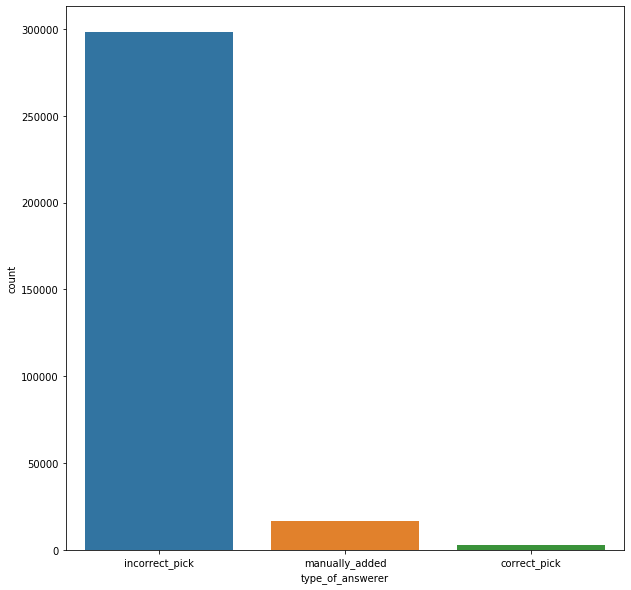

In [17]:
plt.figure(figsize=(10,10))
sb.countplot(all_pairs.type_of_answerer)

fraction_correctly_found = np.count_nonzero(all_pairs.type_of_answerer == "correct_pick") / np.count_nonzero(all_pairs.type_of_answerer != "incorrect_pick")
print("{:.1f}% of true answer candidates selected".format(fraction_correctly_found*100))

# only users with at least one answer 17%
# all users 14.1%
# TTM only users iwth at least one: 11%

In [62]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)
# number of true ones in 

def distributions_of_selection(values, type_of_answerer, 
                               title, xlabel,
                               nan_replace_value=0, **kwargs):
    if nan_replace_value is not None:
        values[np.isnan(values)] = nan_replace_value
    
    manually_added = values[type_of_answerer == "manually_added"]
    correct_candidate = values[type_of_answerer == "correct_pick"]
    incorrect_candidate = values[type_of_answerer == "incorrect_pick"]
    all_candidates = values[type_of_answerer != "manually_added"]

    plt.figure(figsize=(8,6), dpi=400)
    sb.distplot(manually_added, label="TRUE, manually added ", **kwargs)
    sb.distplot(correct_candidate, label="TRUE, candidate", **kwargs)
    sb.distplot(incorrect_candidate, label="FALSE, candidate", **kwargs)
#     sb.distplot(all_candidates, label="all_candidates")
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.gca().axes.get_yaxis().set_ticks([])
    plt.ylabel("density")
#     plt.xlim(0,1)


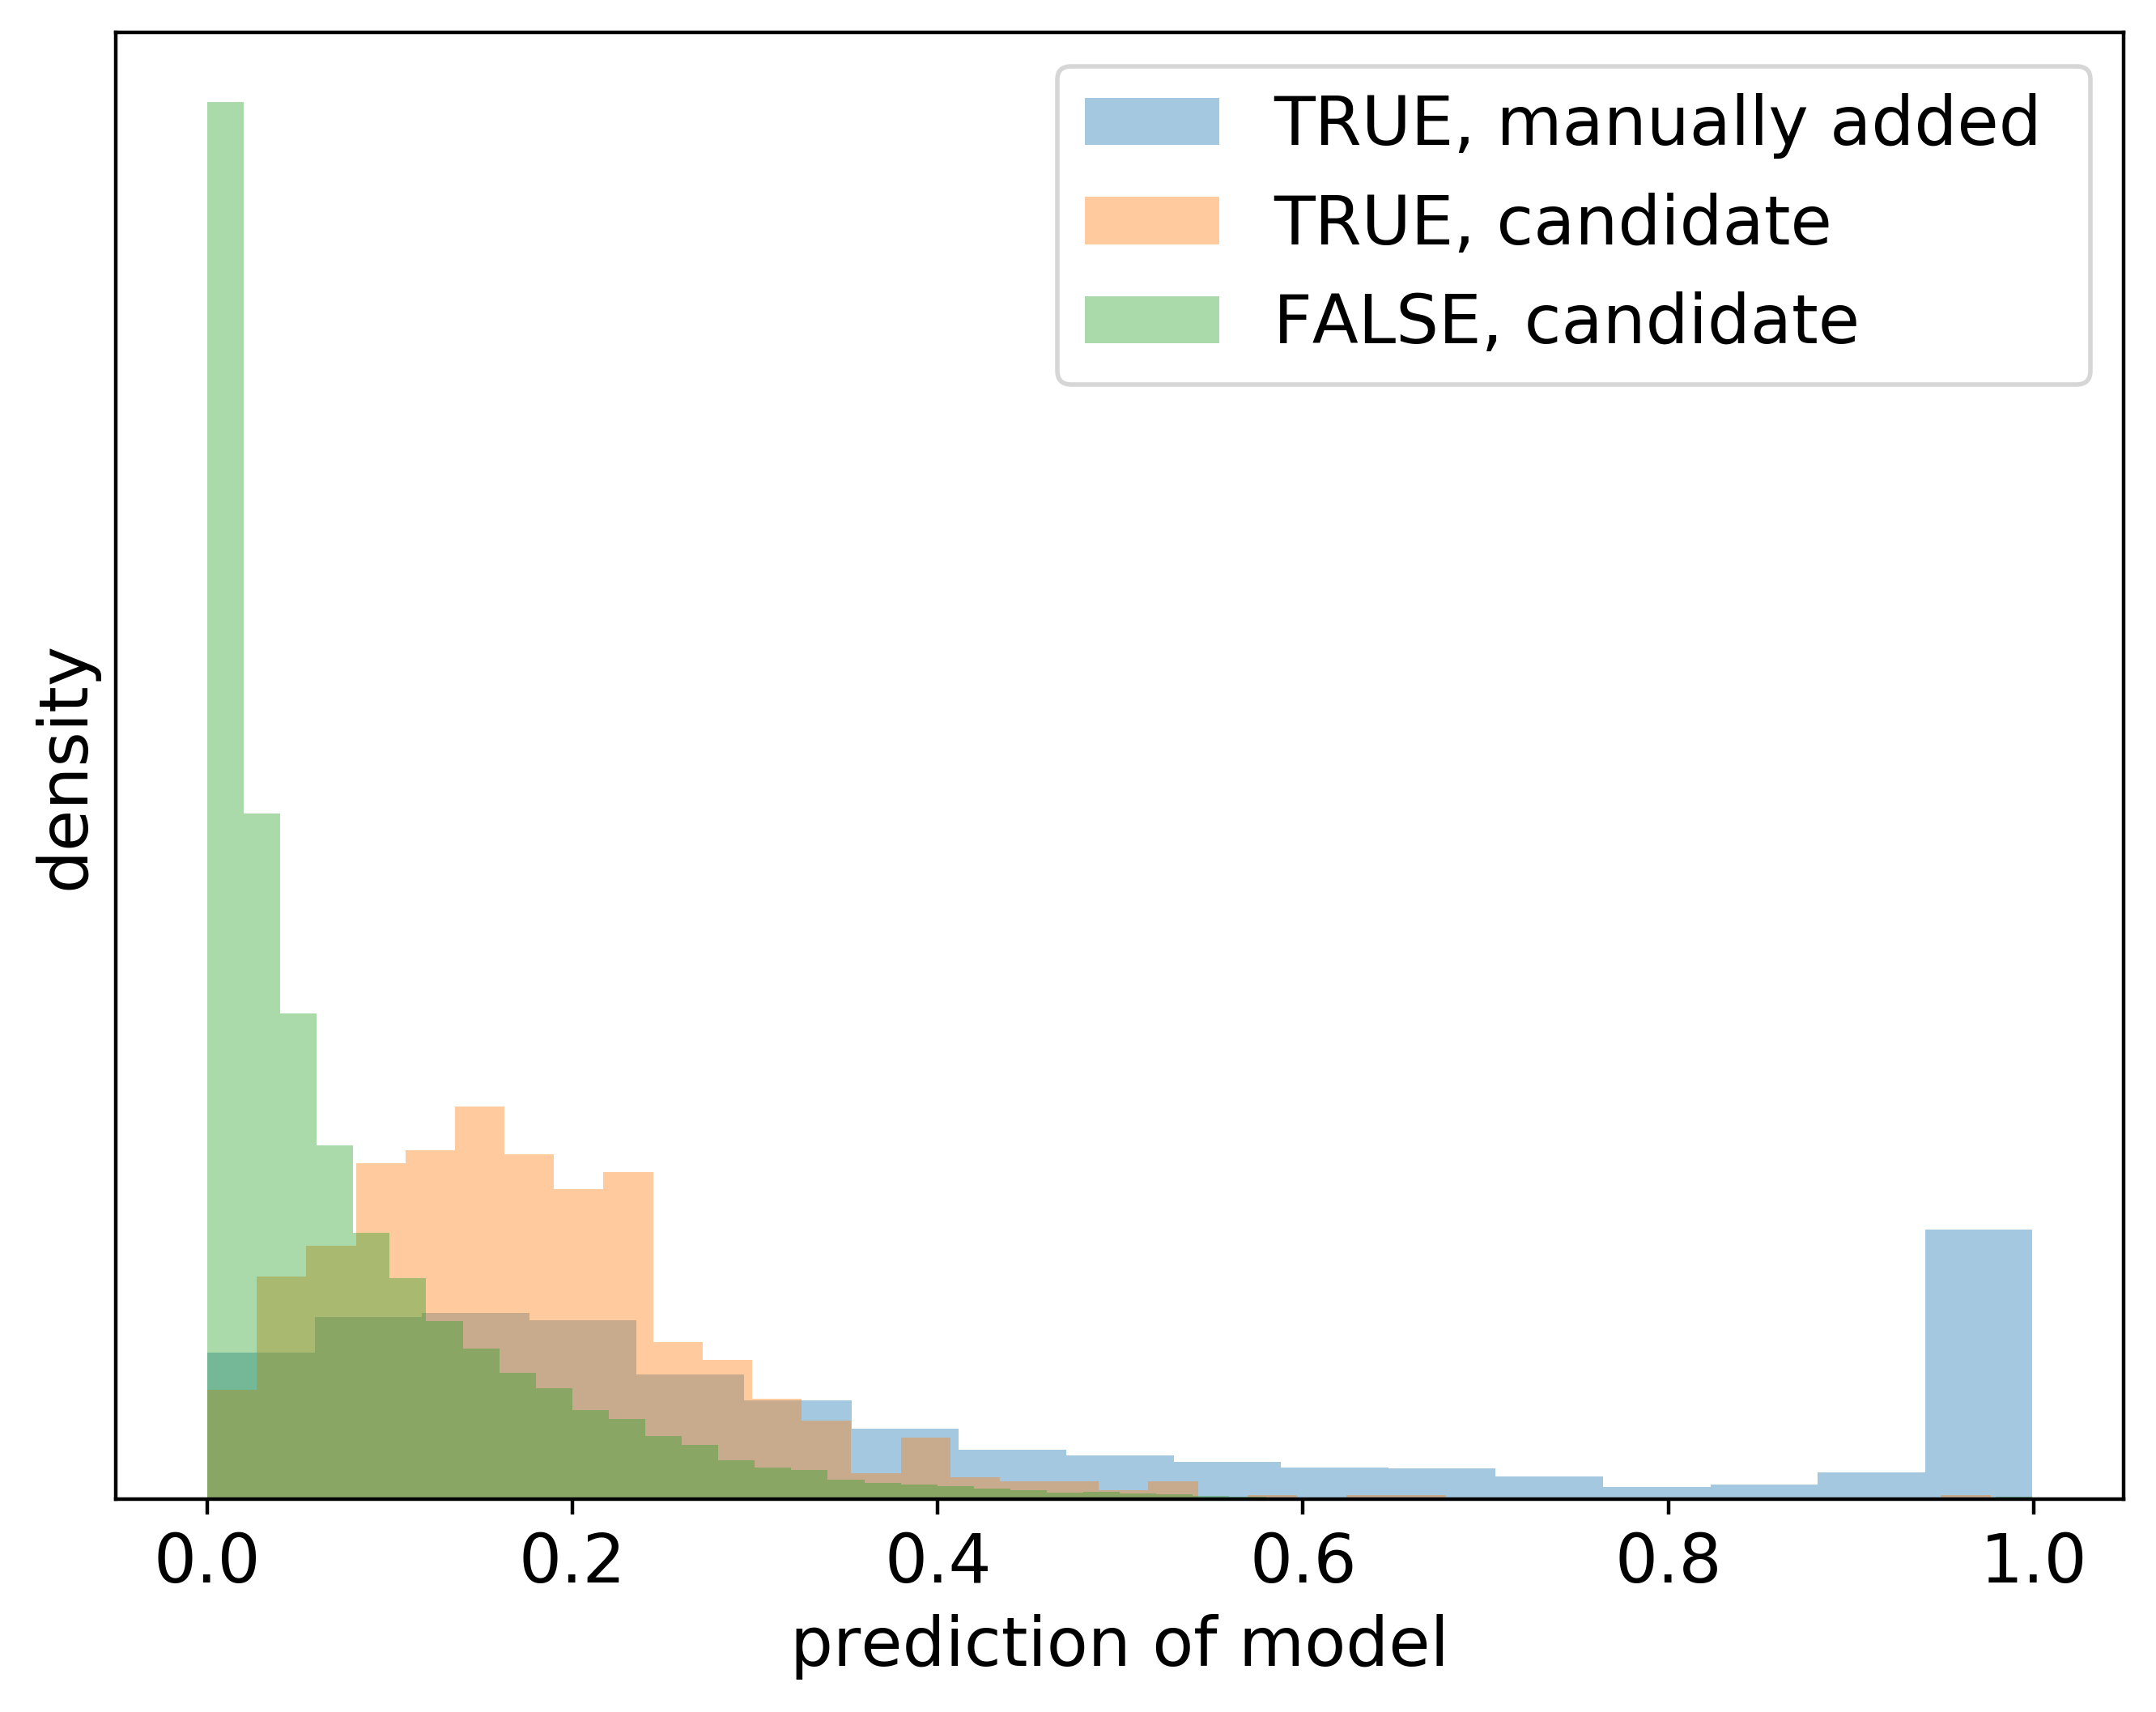

In [63]:
distributions_of_selection(test_y_hat, testing_pairs.type_of_answerer, None,
                           xlabel="prediction of model",
                           kde=False, hist=True, norm_hist=True)
plt.savefig("plots/ch_predictions_raw.pdf")

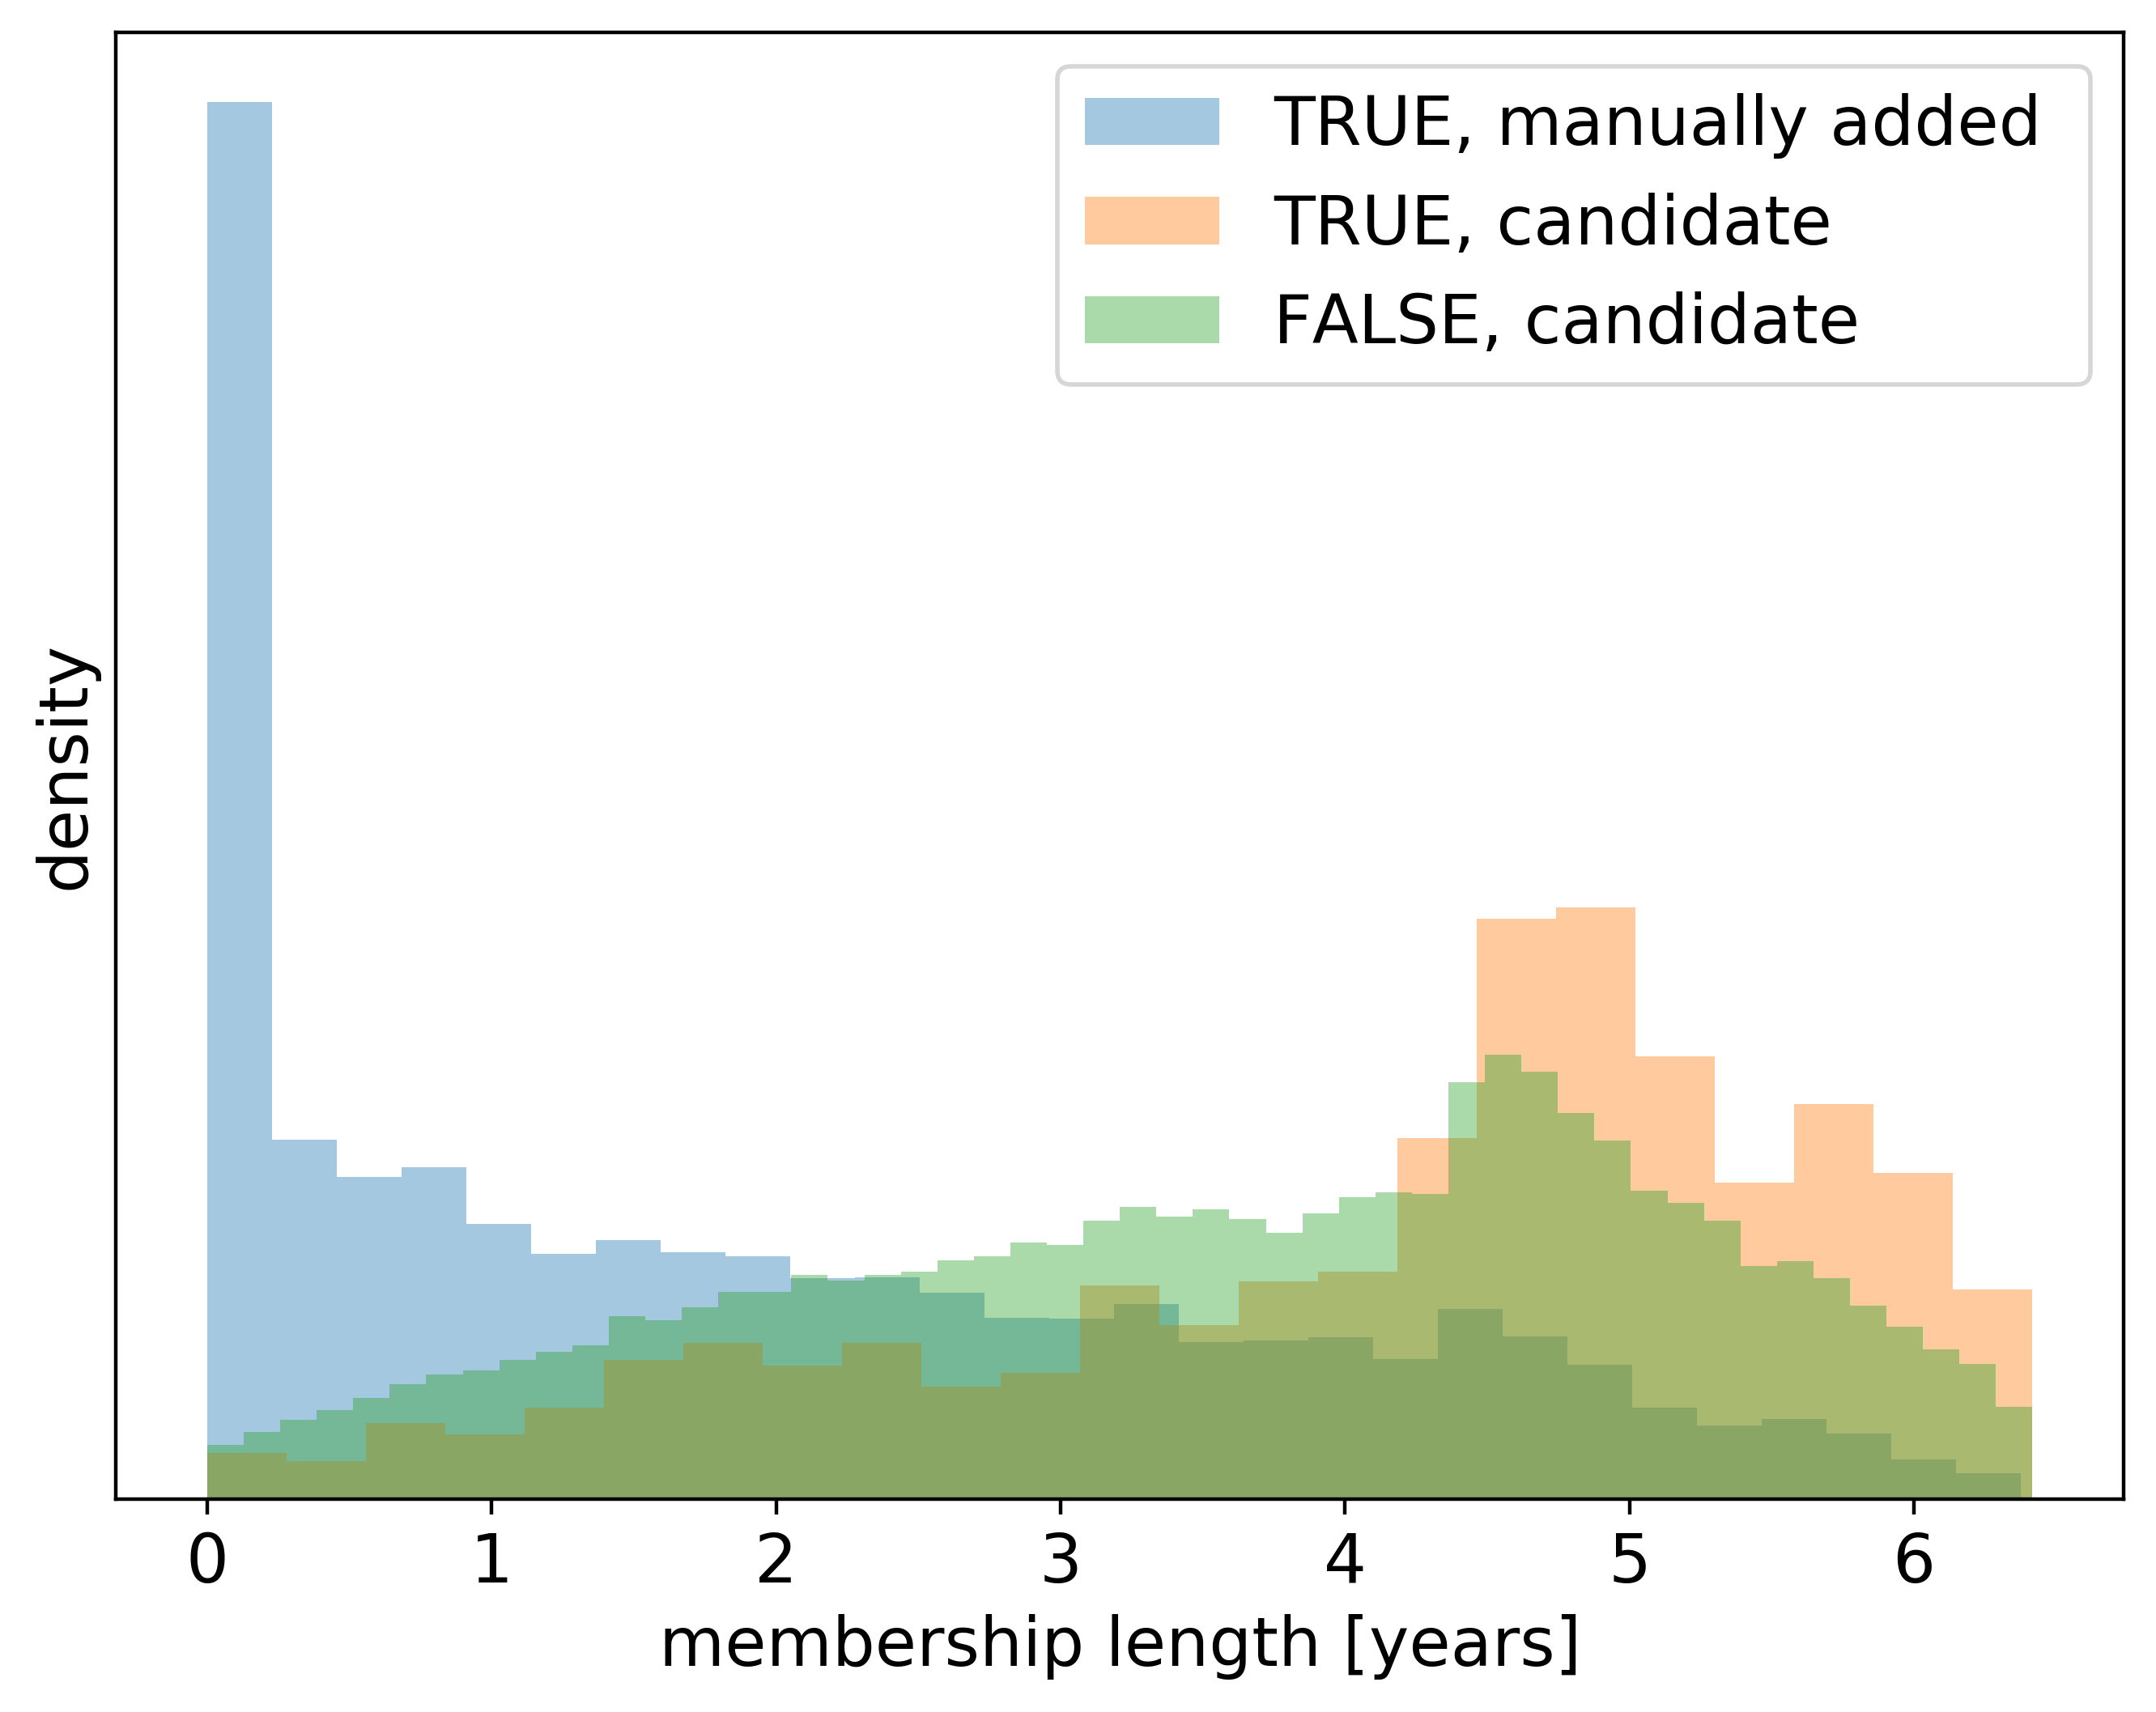

In [66]:
age = all_pairs.plattformage / pd.Timedelta(365, 'D')
distributions_of_selection(age, 
                           all_pairs.type_of_answerer, title=None, xlabel="membership length [years]",
                           kde=False, hist=True, norm_hist=True
                          )
plt.savefig("plots/ch_plattform_age_candidates.pdf")

/Users/clemens/.pyenv/versions/3.7.0/envs/heckoverflow/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


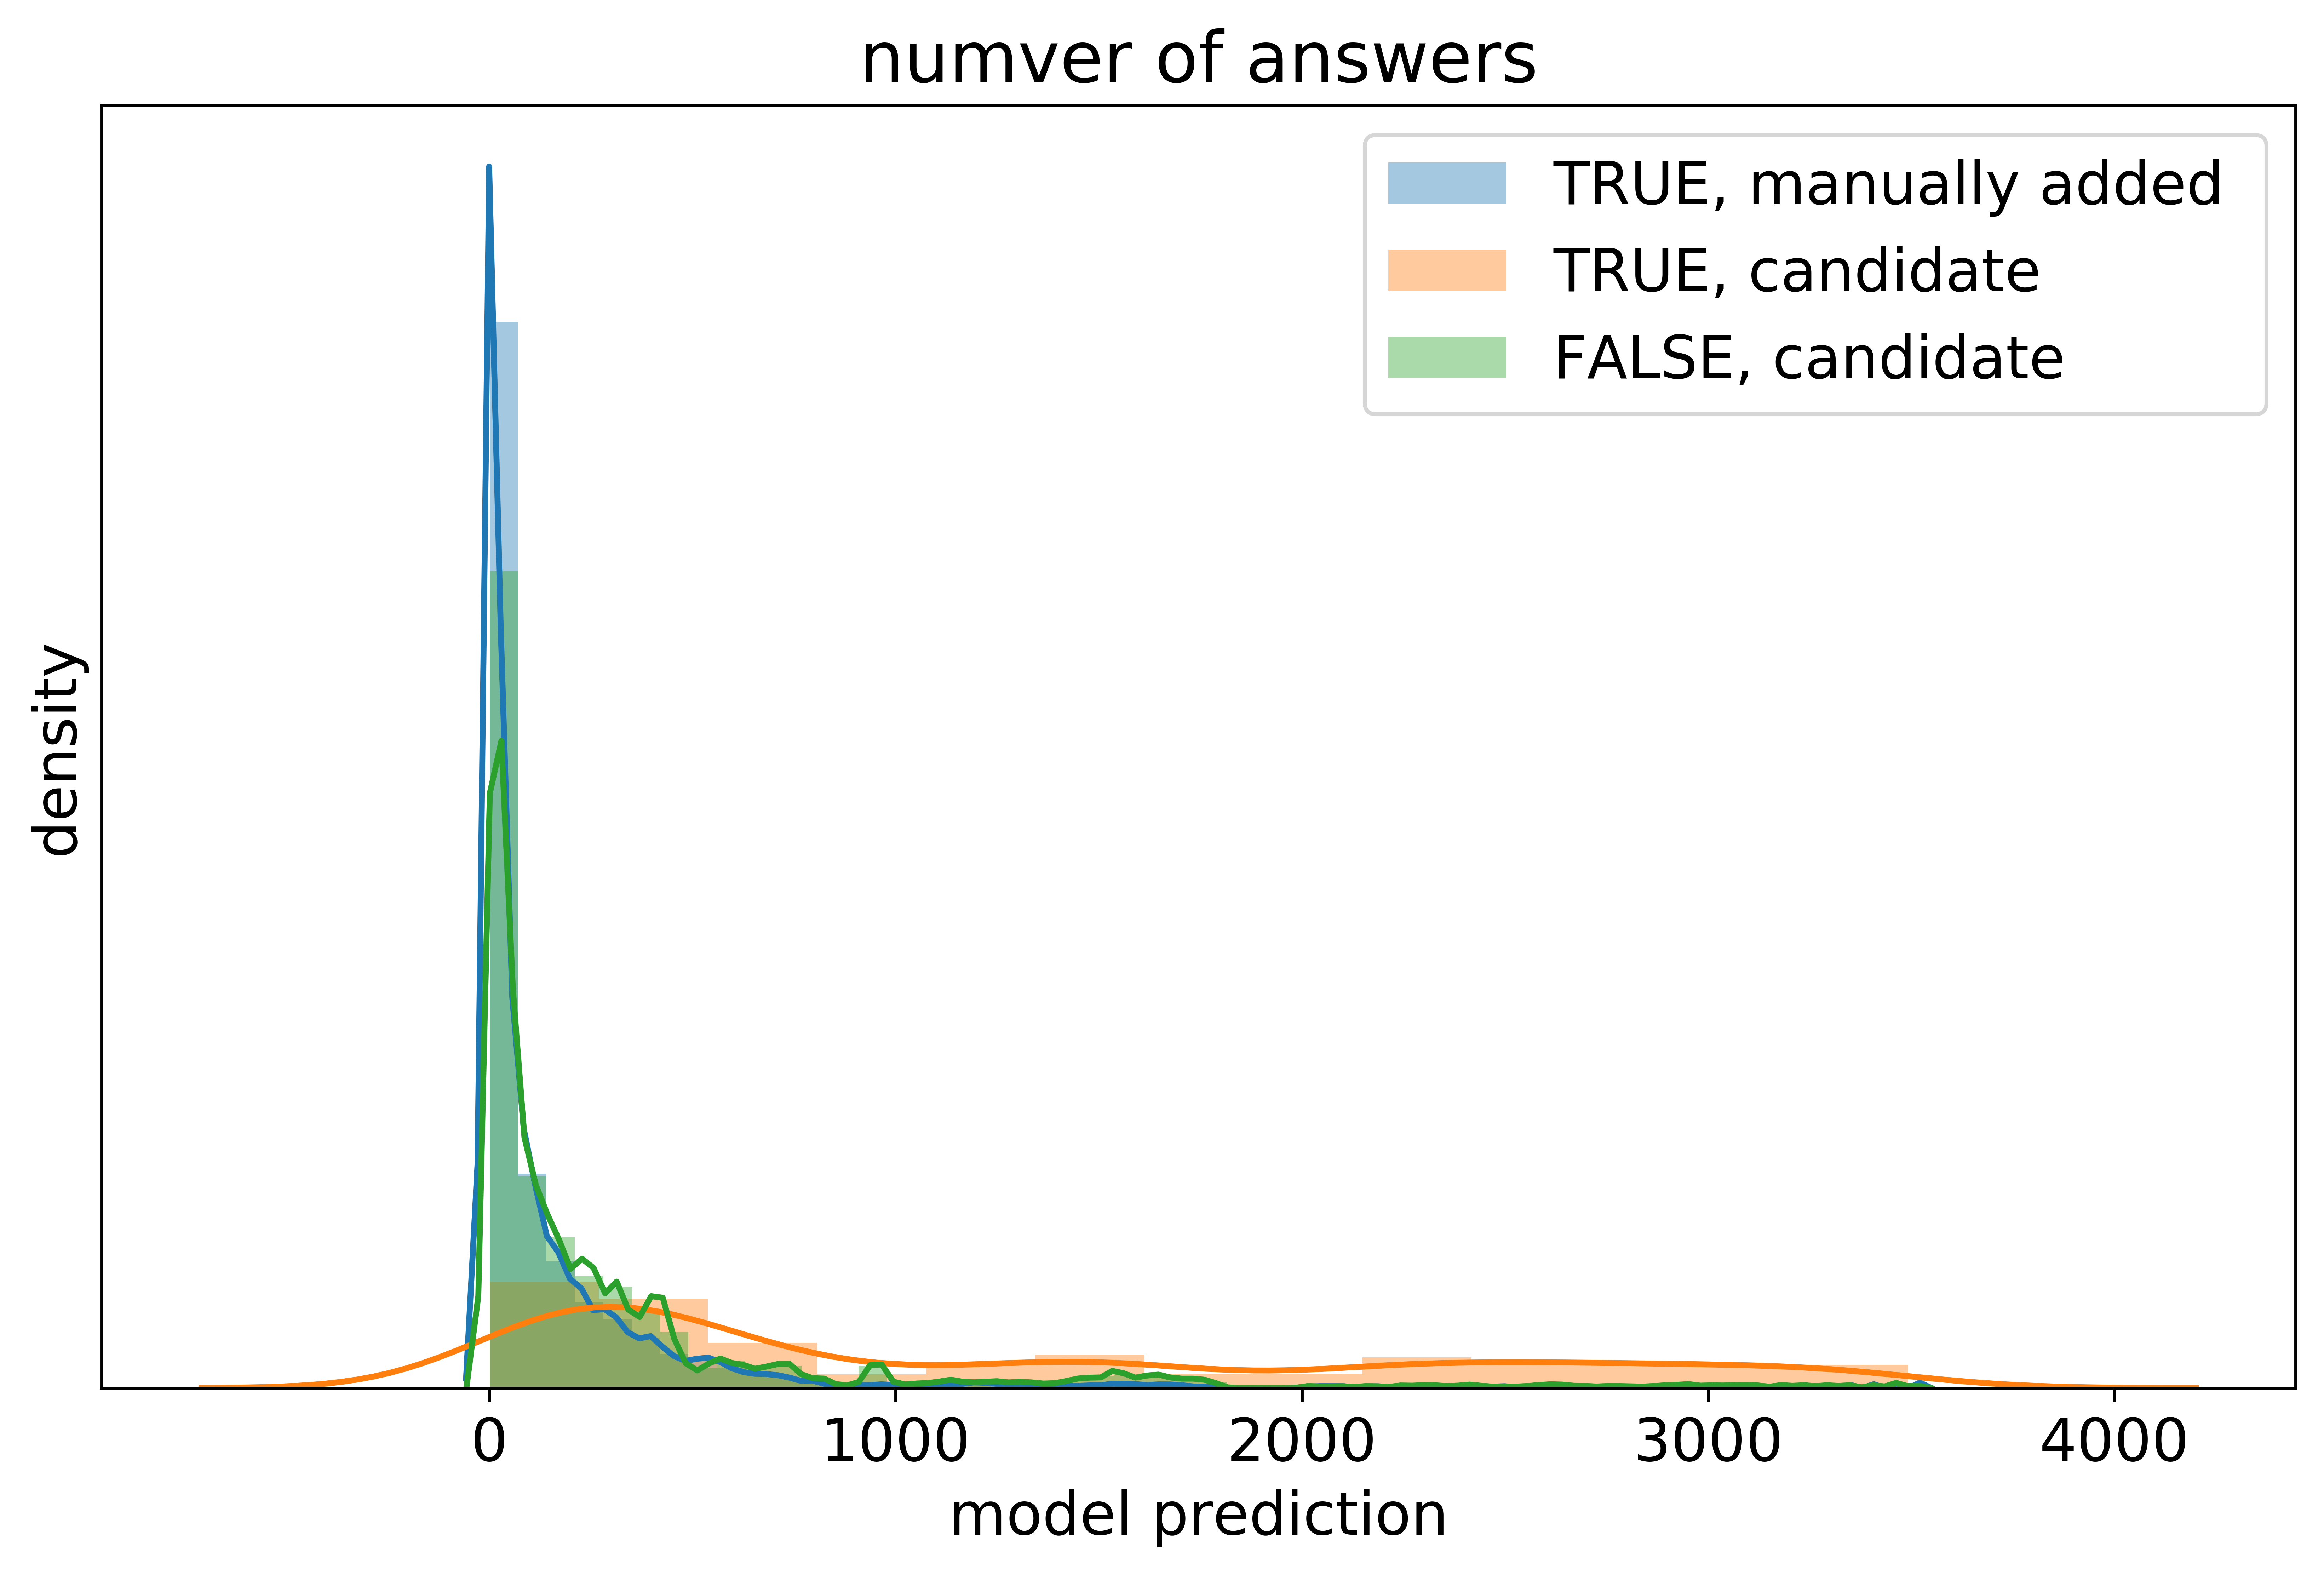

In [21]:
distributions_of_selection(all_pairs.numberanswers, all_pairs.type_of_answerer, "numver of answers", True)

/Users/clemens/.pyenv/versions/3.7.0/envs/heckoverflow/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


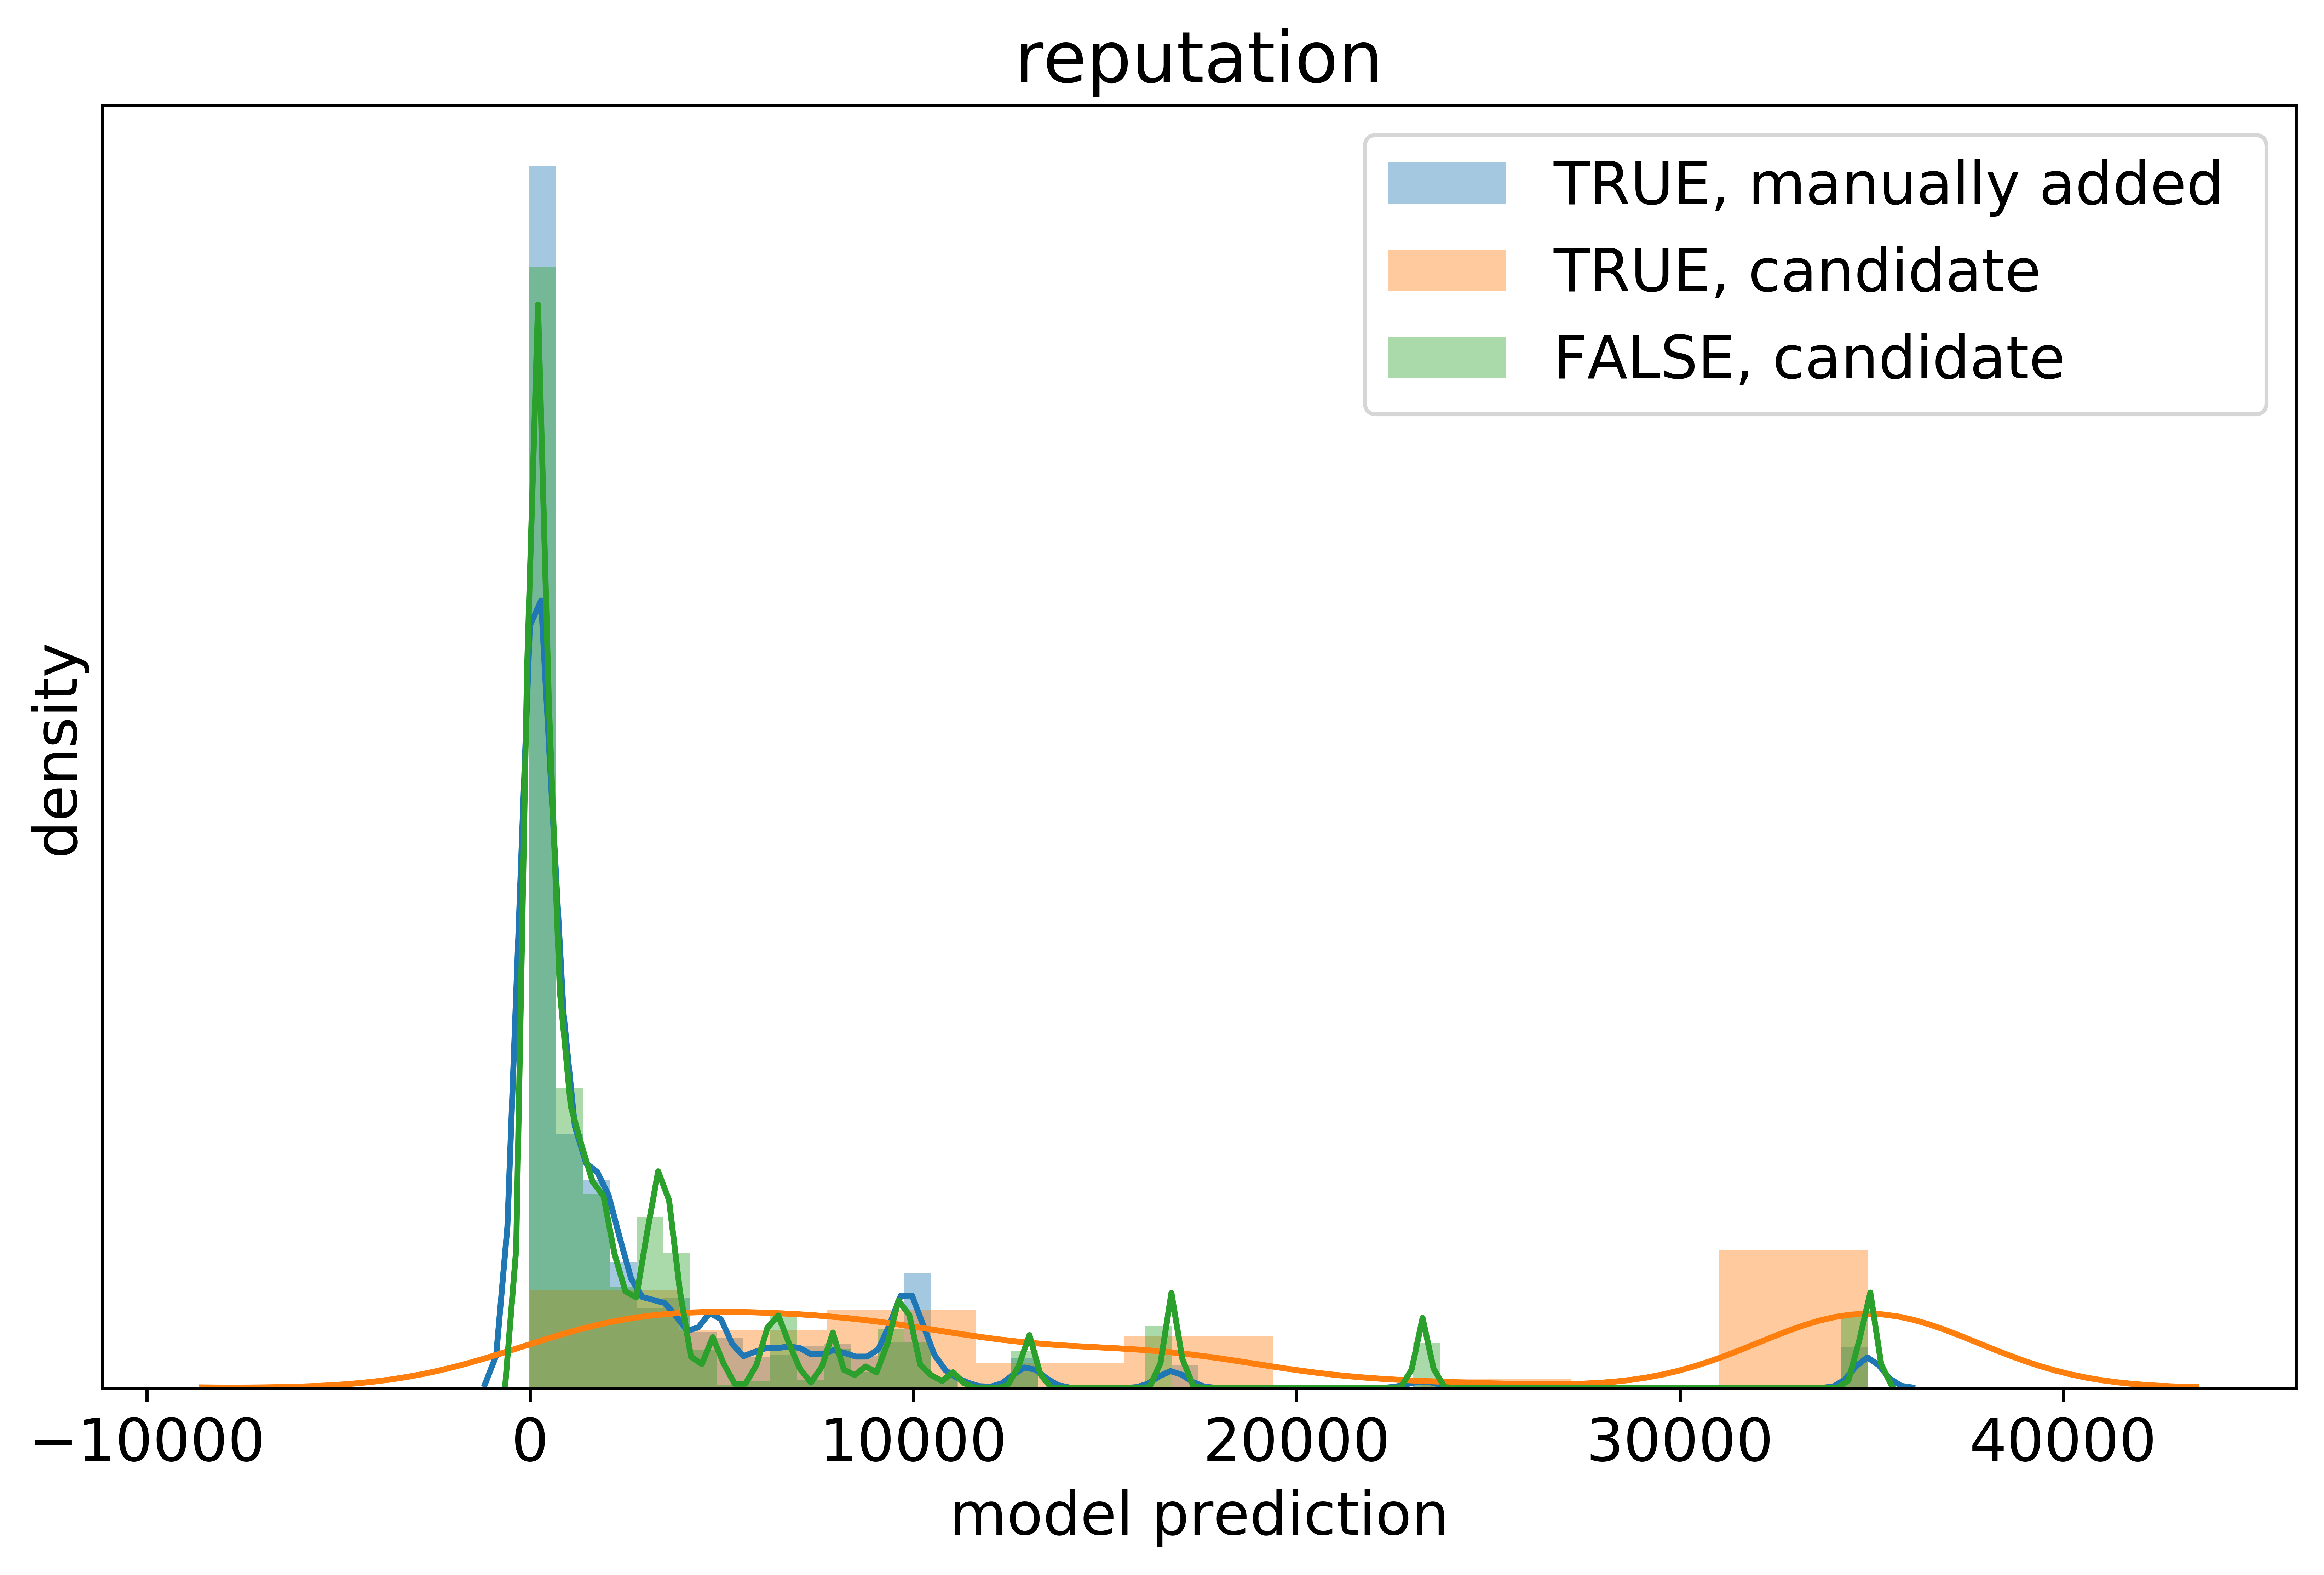

In [22]:
distributions_of_selection(all_pairs.reputation, all_pairs.type_of_answerer, "reputation")

## Load Distribution, numer of questions per user

In [23]:
# TODO see number of questions that user end up in top 5 of 
#TODO how many questions a user got suggest for vs answered
top_n_threshold = 1
testing_pairs["user_was_suggested"] = (testing_pairs.zeroed_predicted_rank <= top_n_threshold)
testing_pairs["user_answered"] = testing_pairs.label
per_user_answers = testing_pairs.groupby('answerer_id')["user_was_suggested", "user_answered"].sum()

/Users/clemens/.pyenv/versions/3.7.0/envs/heckoverflow/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/clemens/.pyenv/versions/3.7.0/envs/heckoverflow/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [24]:
np.corrcoef(per_user_answers.user_was_suggested, per_user_answers.user_answered)

array([[1.        , 0.63390879],
       [0.63390879, 1.        ]])

In [25]:
per_user_answers.sum()

user_was_suggested    4938.0
user_answered         5723.0
dtype: float64

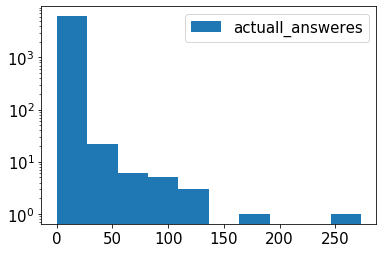

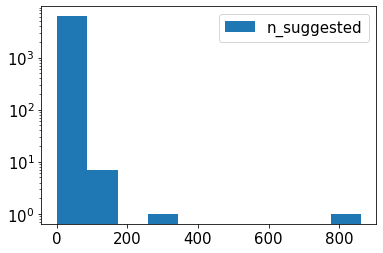

In [26]:
plt.hist(per_user_answers.user_answered, label="actuall_answeres")
plt.legend()
plt.yscale("log")

plt.figure()
plt.hist(per_user_answers.user_was_suggested, label="n_suggested")
plt.legend()
plt.yscale("log")

(-10, 200)

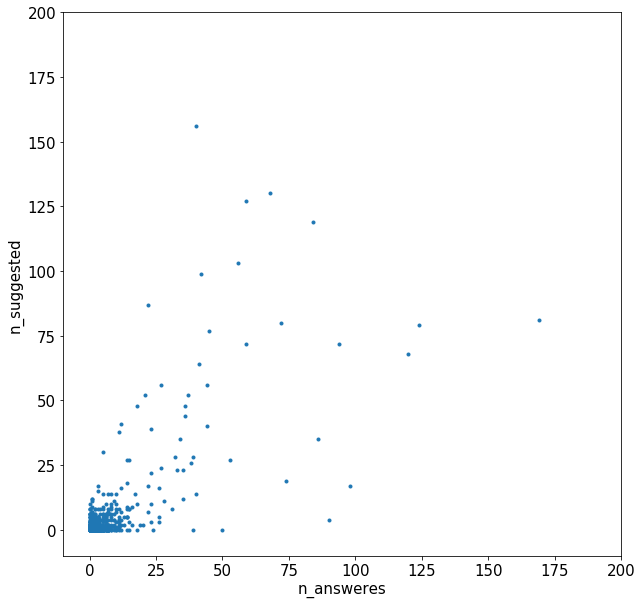

In [27]:

n_answeres = per_user_answers.user_answered
n_suggested = per_user_answers.user_was_suggested
mask = (n_answeres <=200)&(n_suggested<=500)

plt.figure(figsize=(10,10))
plt.scatter(n_answeres[mask], n_suggested[mask], marker='.')
plt.xlabel('n_answeres')
plt.ylabel('n_suggested')
plt.ylim(-10, 200)
plt.xlim(-10,200)

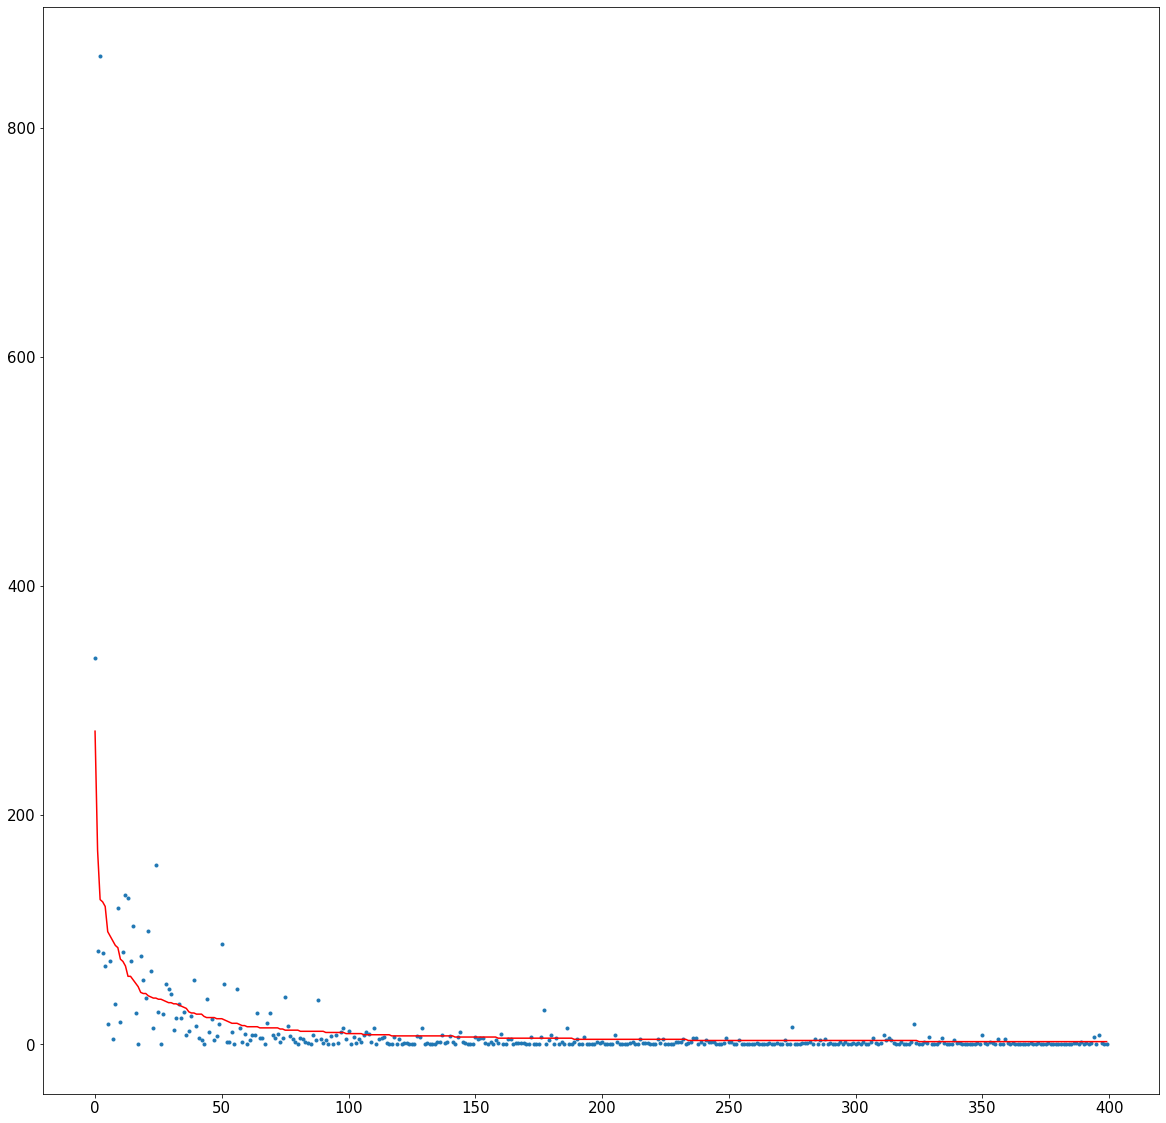

In [28]:
# funny rank plot
sort_ids = np.argsort(-per_user_answers.user_answered.values)
sort_ids = sort_ids[:400]
plt.figure(figsize=(20,20))
plt.plot( np.arange(len(sort_ids)), per_user_answers.user_answered.values[sort_ids], color='red')
plt.scatter(np.arange(len(sort_ids)), per_user_answers.user_was_suggested.values[sort_ids] , marker=".")

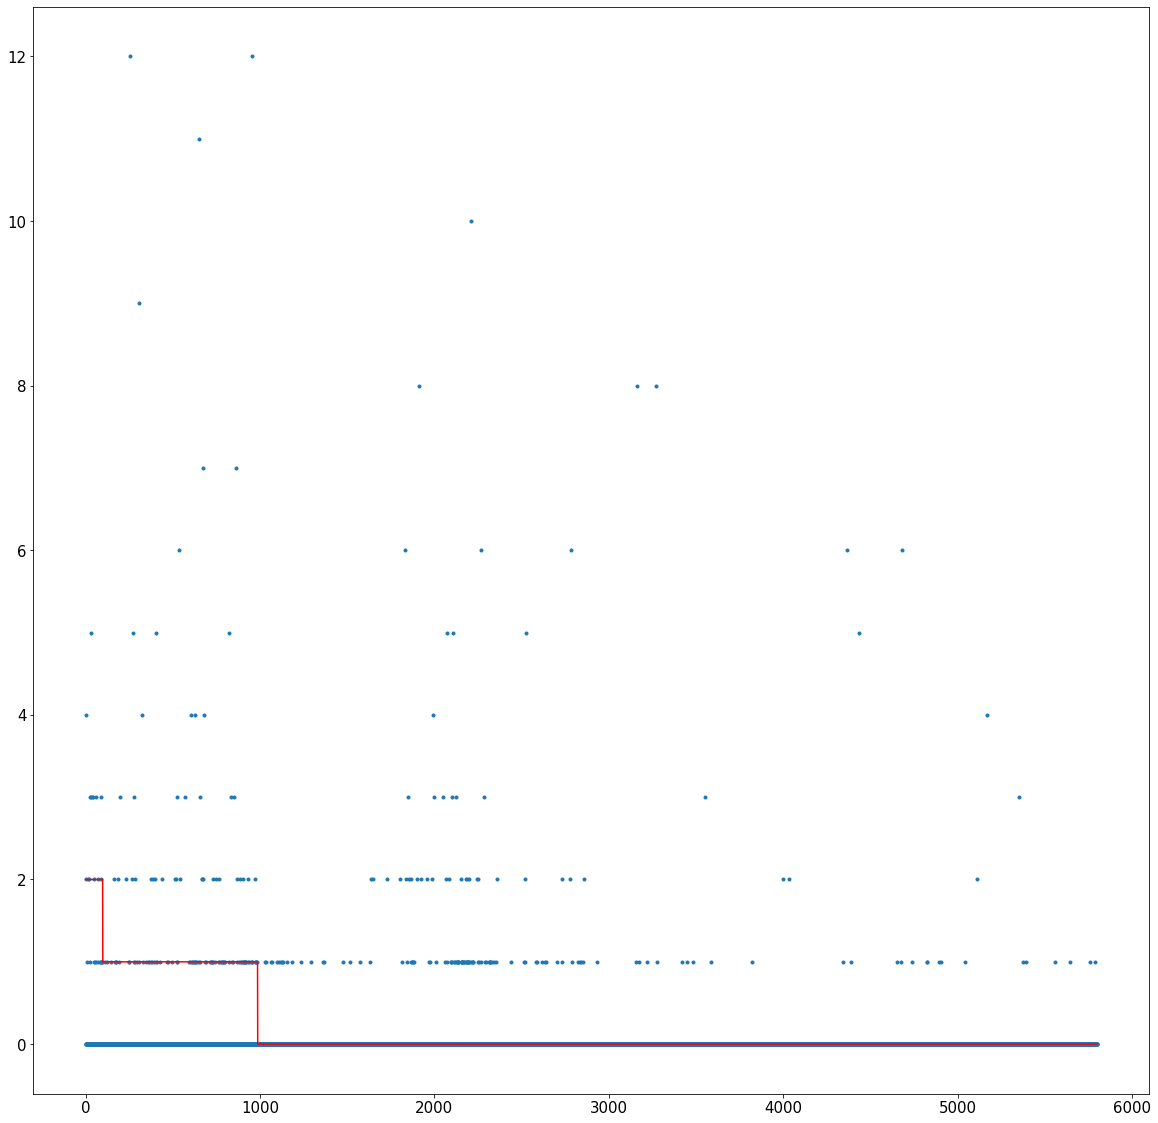

In [29]:
# funny rank plot
sort_ids = np.argsort(-per_user_answers.user_answered.values)
sort_ids = sort_ids[400:]
plt.figure(figsize=(20,20))
plt.plot( np.arange(len(sort_ids)), per_user_answers.user_answered.values[sort_ids], color='red')
plt.scatter(np.arange(len(sort_ids)), per_user_answers.user_was_suggested.values[sort_ids] , marker=".")

## Shuffle manually selected users

In [30]:


user_feature_columns = ['reputation', 'upvotes', 'downvotes', 'plattformage_seconds', 'numberquestions', 'numberanswers', 'numberacceptedanswers']

In [31]:

def shuffle_columns_within_group(dataframe, mask, column_names):
    """for all rows where mask is true, shuffle the values of the columns given by column names."""
    df = dataframe.copy()
    n_elem = np.count_nonzero(mask)
    new_order = np.random.permutation(n_elem)

    for col_name in column_names:
        current_values = df.loc[mask, col_name].values
        shuffled_values = current_values[new_order]
        
        df.loc[mask, col_name] = shuffled_values

    return df

In [32]:
mask = (testing_pairs.type_of_answerer == "manually_added")
fake_test_data = shuffle_columns_within_group(testing_pairs, mask, user_feature_columns)
fake_test_X, fake_test_y = dataframe_to_xy(fake_test_data, feature_cols=feature_cols_for_training)

Didn't find columns set()
Used features: ['titleLength', 'questionLength', 'nCodeBlocks', 'nEquationBlocks', 'nExternalLinks', 'nTags', 'readability', 'reputation', 'upvotes', 'downvotes', 'plattformage_seconds', 'numberquestions', 'numberanswers', 'numberacceptedanswers']
Columns that didn't get picked {'prevalent_topic', 'topic_2', 'question_id', 'label', 'topic_3', 'zeroed_predicted_rank', 'answerer_id', 'topic_0', 'user_was_suggested', 'type_of_answerer', 'topic_1', 'topic_9', 'topic_4', '_reputation_global', 'topic_6', 'user_id', 'index', 'creationdate_user', 'plattformage', 'topic_7', 'topic_5', 'topic_8', 'user_tags', 'creationdate_question', 'user_features_age', 'zeroed_prediction', 'question_tags', 'user_answered'}


In [33]:
fake_test_y_hat = classification_pipeline.predict_proba(fake_test_X)[:, 1]
fake_score, _r = overview_score(y_hat=fake_test_y_hat, y_true=test_y, group=fake_test_data.question_id)
print("Scores with manually added questions shuffled: {}".format(fake_score))

Scores with manually added questions shuffled: {'accuracy': 0.9458696682725699, 'precission': 0.7151932239280042, 'recall': 0.23606500087366766, 'fscore': 0.35496584340514975, 'prediction_values': array([81926,  7657,  1124]), 'mrr_score': 0.6261386121645098, 'mrr_time': 4.8122899532318115, 'label': None}


# Using only the users and not the questions

In [34]:
train_X_user_only, train_y_user_only = dataframe_to_xy(training_pairs, feature_cols=user_feature_columns)
test_X_user_only, test_y_user_only = dataframe_to_xy(testing_pairs, feature_cols=user_feature_columns)

Didn't find columns set()
Used features: ['reputation', 'upvotes', 'downvotes', 'plattformage_seconds', 'numberquestions', 'numberanswers', 'numberacceptedanswers']
Columns that didn't get picked {'nEquationBlocks', 'prevalent_topic', 'question_id', 'label', 'topic_2', 'questionLength', 'topic_3', 'answerer_id', 'topic_0', 'nExternalLinks', 'type_of_answerer', 'nTags', 'topic_1', 'topic_9', 'topic_4', '_reputation_global', 'topic_6', 'titleLength', 'user_id', 'index', 'nCodeBlocks', 'creationdate_user', 'readability', 'plattformage', 'topic_7', 'topic_5', 'topic_8', 'user_tags', 'creationdate_question', 'user_features_age', 'question_tags'}
Didn't find columns set()
Used features: ['reputation', 'upvotes', 'downvotes', 'plattformage_seconds', 'numberquestions', 'numberanswers', 'numberacceptedanswers']
Columns that didn't get picked {'nEquationBlocks', 'prevalent_topic', 'question_id', 'label', 'topic_2', 'questionLength', 'topic_3', 'zeroed_predicted_rank', 'answerer_id', 'topic_0', '

/Users/clemens/.pyenv/versions/3.7.0/envs/heckoverflow/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [35]:
classification_pipeline_user_only = sklearn.base.clone(classification_pipeline)
classification_pipeline_user_only.fit(train_X_user_only, train_y_user_only)

Pipeline(memory=None,
         steps=[('impute',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=0,
                               missing_values=nan, strategy='constant',
                               verbose=0)),
                ('rf',
                 RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                        criterion='gini', max_depth=50,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1e-05,
                                        min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=1,
                                        oob_score=False, random_s

In [36]:
test_y_hat_user_only = classification_pipeline_user_only.predict_proba(test_X_user_only)[:, 1]
test_score_user_only, _r = overview_score(y_hat=test_y_hat_user_only, y_true = testing_pairs.label, group=testing_pairs.question_id)
print("User Only score: {}".format(test_score_user_only))

User Only score: {'accuracy': 0.9105691953211991, 'precission': 0.3304471256210078, 'recall': 0.4067796610169492, 'fscore': 0.3646616541353384, 'prediction_values': array([66487, 22723,  1497]), 'mrr_score': 0.5665278202606188, 'mrr_time': 6.311991214752197, 'label': None}


In [37]:
utils.print_feature_importance(classification_pipeline_user_only.named_steps['rf'].feature_importances_, user_feature_columns)

Importance 0.282 of Feature plattformage_seconds 
Importance 0.207 of Feature reputation 
Importance 0.168 of Feature numberanswers 
Importance 0.160 of Feature upvotes 
Importance 0.093 of Feature numberacceptedanswers 
Importance 0.048 of Feature numberquestions 
Importance 0.043 of Feature downvotes 
